In [4]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [13]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

# 1. ЗАГРУЗКА
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. FEATURE ENGINEERING (БЕЗ ЛАГОВ)
def create_smart_features(df, train_ref=None):
    # А) Глобальная статистика цен (только из Train!)
    if train_ref is not None:
        # Средняя цена товара за всё время
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        
        # Средняя цена категории
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
    
    # Б) Относительная представленность
    # Насколько широко представлен товар относительно среднего в категории
    cat_stores_map = df.groupby('third_category_id')['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    
    # В) Погодные фичи (Ощущаемая температура)
    # Упрощенная формула: Температура + влажность
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    
    # Г) Интенсивность конкуренции
    # Сколько разных товаров в той же категории продается в этот день
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    
    return df

# Применяем (передаем train как справочник для средних цен)
train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

# 3. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ (как у тебя)
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ
cat_features = [
    'management_group_id', 'first_category_id', 
    # 'second_category_id', 
    # 'third_category_id', 
    # 'product_id', 
    'activity_flag'
    # 'holiday_flag'
]

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year',
    # 'dow_sin', 'dow_cos',
    'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth'
] + cat_features

# Заполняем NaN (если в тесте новые категории/товары)
train[features] = train[features].fillna(train[features].mean(numeric_only=True))
test[features] = test[features].fillna(train[features].mean(numeric_only=True))

# 5. ВАЛИДАЦИЯ И ОБУЧЕНИЕ (Квантильная регрессия)
# Используем твой метод разбиения 80/20 внутри дня
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=42)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

cb_params = {
    'iterations': 2500,
    'learning_rate': 0.03,
    'depth': 7,
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 200,
}

# Модели
model_low = CatBoostRegressor(loss_function='MAE', **cb_params)
model_high = CatBoostRegressor(loss_function='MAE', **cb_params)

print("Обучение Low...")
model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

print("Обучение High...")
model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

# 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ (с исправлением передачи аргументов)
print("Обучение финальных моделей на полном датасете...")

# Создаем настройки для финальных моделей на основе лучших итераций
# Мы извлекаем базовые параметры и заменяем в них итерации
final_params_low = cb_params.copy()
final_params_low['iterations'] = model_low.get_best_iteration() + 1
final_params_low.pop('early_stopping_rounds', None) # На финале стоппинг не нужен

final_params_high = cb_params.copy()
final_params_high['iterations'] = model_high.get_best_iteration() + 1
final_params_high.pop('early_stopping_rounds', None)

# Инициализируем модели
final_low = CatBoostRegressor(loss_function='MAE', 
                              allow_writing_files=False, 
                              **final_params_low)

final_high = CatBoostRegressor(loss_function='MAE', 
                               allow_writing_files=False, 
                               **final_params_high)

# Обучаем на всех данных (train)
print(f"Финальный запуск Low ({final_params_low['iterations']} ит.)...")
final_low.fit(train[features], train['price_p05'], 
              cat_features=cat_features, 
              verbose=100)

print(f"Финальный запуск High ({final_params_high['iterations']} ит.)...")
final_high.fit(train[features], train['price_p95'], 
               cat_features=cat_features, 
               verbose=100)

# 7. ПРЕДСКАЗАНИЕ И СОХРАНЕНИЕ
print("Создание предсказаний...")
test['price_p05'] = final_low.predict(test[features])
test['price_p95'] = final_high.predict(test[features])

# Логическая проверка: p95 не может быть меньше p05
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

# Сохраняем результат
submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission.csv', index=False)
print("Готово! Файл submission.csv успешно сохранен.")

Обучение Low...
0:	learn: 0.1463165	test: 0.1458389	best: 0.1458389 (0)	total: 24.4ms	remaining: 1m 1s
100:	learn: 0.0910579	test: 0.0927216	best: 0.0927216 (100)	total: 2.31s	remaining: 55s
200:	learn: 0.0878104	test: 0.0915040	best: 0.0915022 (198)	total: 4.66s	remaining: 53.3s
300:	learn: 0.0861496	test: 0.0915194	best: 0.0914432 (268)	total: 6.95s	remaining: 50.8s
400:	learn: 0.0846573	test: 0.0915918	best: 0.0914432 (268)	total: 9.2s	remaining: 48.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.09144317068
bestIteration = 268

Shrink model to first 269 iterations.
Обучение High...
0:	learn: 0.0984789	test: 0.0982400	best: 0.0982400 (0)	total: 22.8ms	remaining: 57.1s
100:	learn: 0.0856939	test: 0.0900024	best: 0.0898955 (86)	total: 2.27s	remaining: 54s
200:	learn: 0.0830759	test: 0.0902685	best: 0.0898955 (86)	total: 4.47s	remaining: 51.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.08989548991
bestIteration = 86

Shrink model to fir

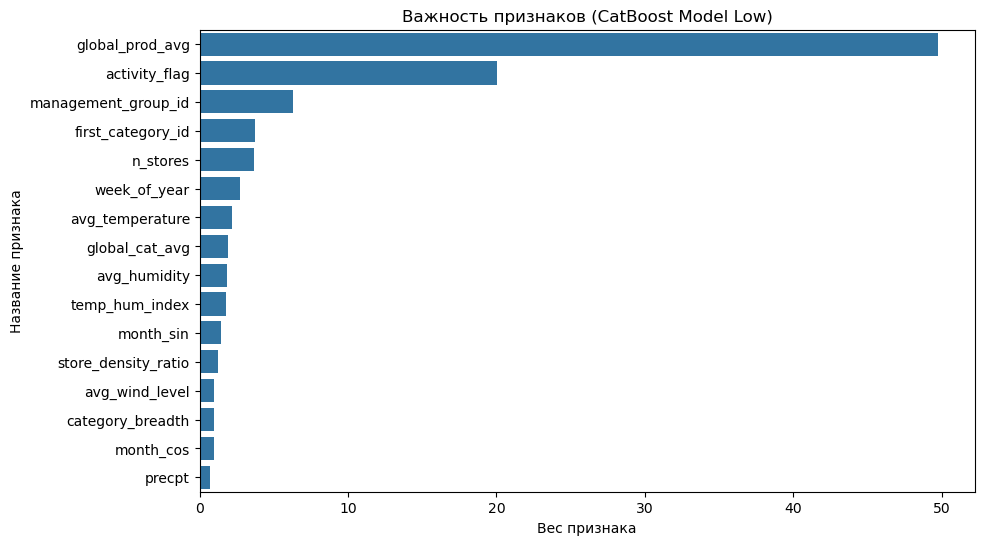

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()